# SegMate Demo Notebook

Welcome to the SegMate demo notebook! In this notebook, we will showcase the capabilities of SegMate, a Segment Anything Model Toolkit developed by AI Engineering team at Vector Institute.

## SegMate: A Segment Anything Model Toolkit

SegMate is a powerful toolkit that utilizes the Segment Anything Model (SAM) developed by Meta AI. SAM is a promptable segmentation system capable of accurately "cutting out" any object from an image with just a single click. It exhibits zero-shot generalization to unfamiliar objects and images, eliminating the need for additional training.

## SAM Architecture

SAM utilizes a sophisticated architecture comprising three key components: the image encoder, the prompt encoder, and the mask decoder.

- **Image Encoder**: Captures essential features from the input image, extracting high-level representations that encode relevant information about objects and their context. This step allows SAM to understand the visual content of the image.

- **Prompt Encoder**: Processes user-provided prompts, such as bounding boxes, points, or text, and transforms them into meaningful representations. These representations guide SAM to understand the desired object to be segmented.

- **Mask Decoder**: Generates precise segmentation masks by leveraging the encoded information from both the image encoder and the prompt encoder. It efficiently processes the features and produces detailed object boundaries, enabling near real-time segmentation results.

Let's start by importing the necessary libraries:

In [1]:
from segmate.segmate import SegMate
import segmate.utils as utils
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

/scratch/ssd004/scratch/vkhazaie/sam/lib/python3.9/site-packages/groundingdino/models/GroundingDINO/ms_deform_attn.py:31: UserWarning: Failed to load custom C++ ops. Running on CPU mode Only!
  warnings.warn("Failed to load custom C++ ops. Running on CPU mode Only!")


### Initializing SegMate

To start using SegMate, we need to create an instance of the SegMate class. Here, we create an instance called `sm` with the following parameters:

- `model_type`: Specifies the type of model to use. In this case, we are using the `vit_b` model. The options are `vit_b`, `vit_l` and `vit_h`.
- `checkpoint`: Specifies the path to the checkpoint file that contains the pre-trained weights of the model.
- `device`: Specifies the device to run the model on. In this case, we are using the `cuda` device for GPU acceleration.
- `object_detector`: Optional parameter that allows you to provide a custom object detector when you want to use the model with text prompt. If not specified, the default object detector is `None`. You can always add the `object_detector` later.

This instance of the SegMate class serves as our toolkit for performing segmentation tasks with SAM. It encapsulates the model and provides convenient methods for inference and fine-tuning.

Let's create the instance and load the model:

In [2]:
model_checkpoint = '/ssd003/projects/aieng/image_models/sam_vit_b.pth'

In [3]:
sm = SegMate(model_type='vit_b', checkpoint=model_checkpoint, device='cuda', object_detector=None)

### Using Building Image Segmentation Dataset

In this section, we will demonstrate how to load and utilize the Building Image Segmentation dataset, which is available in the HuggingFace datasets library. We will load the mini version of the dataset and retrieve the bounding box, segmentation mask, and image of a sample from the training set.

To begin, we import the necessary libraries and load the dataset using the `load_dataset()` function from the HuggingFace🤗 datasets library:

In [4]:
from datasets import load_dataset

dataset = load_dataset("keremberke/satellite-building-segmentation", "mini")

### Training a custom decoder for Building Image Segmentation Dataset

In this section, we will demonstrate how to create a PyTorch Dataset instance from the Building Image Segmentation (BIS) dataset and train a custom decoder on this dataset using the SegMate toolkit.

Let's take a look at the code snippet:

In [5]:
from segmate.dataset import BISDataset
from tqdm import tqdm
bis_dataset = BISDataset(dataset=dataset['train'],
                         preprocess=sm.sam.preprocess,
                         img_size=sm.sam.image_encoder.img_size,
                         device=sm.device)

In [6]:
bis_dataloader = sm.get_dataset(bis_dataset)

In [10]:
class SegmentationDecoder(nn.Module):
    def __init__(self, in_channels=256):
        super(SegmentationDecoder, self).__init__()

        # Upsampling layers
        self.upconv1 = nn.ConvTranspose2d(in_channels, 128, kernel_size=4, stride=2, padding=1)
        self.upconv2 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.upconv3 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.upconv4 = nn.ConvTranspose2d(32, 16, kernel_size=4, stride=1, padding=1)
        
        # Final convolution to reach the desired number of channels (1)
        self.final_conv = nn.Conv2d(16, 1, kernel_size=14)

    def forward(self, x):
        x = self.upconv1(x)
        x = self.upconv2(x)
        x = self.upconv3(x)
        x = self.upconv4(x)
        x = self.final_conv(x)

        return x

In [11]:
decoder = SegmentationDecoder(in_channels=256)
decoder.to(sm.device)

SegmentationDecoder(
  (upconv1): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (upconv2): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (upconv3): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (upconv4): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (final_conv): Conv2d(16, 1, kernel_size=(14, 14), stride=(1, 1))
)

In [12]:
# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  # Binary Cross Entropy Loss with logits
optimizer = optim.Adam(decoder.parameters(), lr=0.001)  # Adam optimizer

# Assuming you have already initialized the dataloader 'bis_dataloader' and the decoder 'decoder'
# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    decoder.train()  # Set the decoder to training mode
    running_loss = 0.0
    n = 0
    for input_image, _, gt_mask in tqdm(bis_dataloader):
        if n > 50:
            break
        if gt_mask.shape[2:] == (500, 500):
            optimizer.zero_grad()

            # Forward pass
            features = sm.sam.image_encoder(input_image)
            output_mask = decoder(features)

            # Calculate the loss
            loss = criterion(output_mask, gt_mask)

            # Backpropagation and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            n = n + 1
        

    epoch_loss = running_loss / len(bis_dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss:.4f}")

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.20s/it]


Epoch [1/10] - Loss: 0.6368


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.18s/it]


Epoch [2/10] - Loss: 0.5925


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


Epoch [3/10] - Loss: 0.4277


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.19s/it]


Epoch [4/10] - Loss: 0.4131


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]


Epoch [5/10] - Loss: 0.3123


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.20s/it]


Epoch [6/10] - Loss: 0.2046


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.20s/it]


Epoch [7/10] - Loss: 0.1585


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.19s/it]


Epoch [8/10] - Loss: 0.1381


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.20s/it]


Epoch [9/10] - Loss: 0.1236


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]

Epoch [10/10] - Loss: 0.0946


In [48]:
dataset = load_dataset("keremberke/satellite-building-segmentation", "mini")

test_bis_dataset = BISDataset(dataset=dataset['validation'],
                         preprocess=sm.sam.preprocess,
                         img_size=sm.sam.image_encoder.img_size,
                         device=sm.device)
test_bis_dataloader = sm.get_dataset(test_bis_dataset)

In [49]:
# Set the decoder to evaluation mode
decoder.eval()

SegmentationDecoder(
  (upconv1): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (upconv2): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (upconv3): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (upconv4): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (final_conv): Conv2d(16, 1, kernel_size=(14, 14), stride=(1, 1))
)

In [50]:
for input_image, _, gt_mask in tqdm(test_bis_dataloader):
    with torch.no_grad():
        features = sm.sam.image_encoder(input_image)
        output_mask = decoder(features)
        
    break

  0%|                                                                                                       | 0/3 [00:00<?, ?it/s]


In [51]:
from torch.nn import functional as F

# Apply a threshold to get the binary mask
thresholded_mask = F.threshold(output_mask, 0.0, 0)
binary_mask = F.normalize(thresholded_mask)

# Convert the binary mask tensor to a numpy array and remove the batch dimension
binary_mask = binary_mask.squeeze(0).cpu().numpy()

In [52]:
binary_mask.shape

(1, 500, 500)

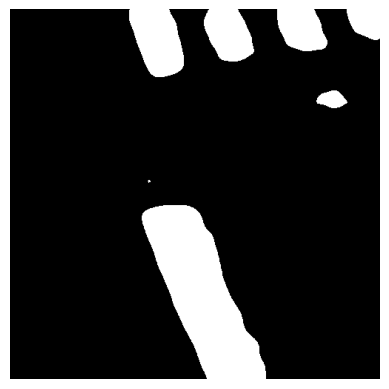

In [53]:
utils.show_image(binary_mask.reshape(500, 500))

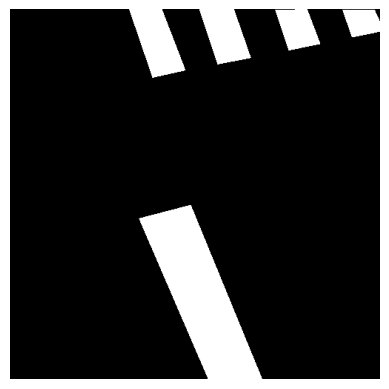

In [54]:
utils.show_image(gt_mask.cpu().numpy().reshape(500, 500))